# Set up and process metadata

In [12]:

import csv
import numpy as np
from dataclasses import dataclass
from sys import argv

def normalize(results, spec_to_metadata = None):
    total = 0
    if spec_to_metadata:
        for key,thing in results.items():
            size = float(spec_to_metadata[key]['genome_size'])
            total += size * thing.seq_abund
        for key, thing in results.items():
            size = float(spec_to_metadata[key]['genome_size'])
            thing.seq_abund = thing.seq_abund * size / total
    else:
        for thing in results.values():
            total += thing.seq_abund 
        for thing in results.values():
            thing.seq_abund = thing.seq_abund/total

@dataclass
class tax_result:
    species: str
    genus: str
    abund: float
    seq_abund: float

@dataclass
class gen_abund:
    genus: str
    seq_abund: float

def get_spec_to_metadata(file_path, ganon_input):
    used_genomes = set()
    with open(ganon_input,'r') as f:
        for line in f:
            used = line.split('\t')[0].split('/')[-1].split('.fa')[0]
            used_genomes.add(used)
    spec_to_metadata = {}
    with open(file_path, 'r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')
        for row in csv_reader:
            if row['accession'] in used_genomes:
                spec = row['gtdb_taxonomy'].split(';')[-1]
                spec_to_metadata[spec] = row
            # if row['gtdb_representative'] == 'y':
            #     spec = row['gtdb_taxonomy'].split(';')[-1]
            #     spec_to_metadata[spec] = row
            # elif row['gtdb_taxonomy'].split(';')[-1] not in spec_to_metadata:
            #     spec = row['gtdb_taxonomy'].split(';')[-1]
            #     spec_to_metadata[spec] = row
    return spec_to_metadata

def read_ganon_file(file_path, species_name_to_spec_and_genus, spec_to_metadata):
    taxonomic_data = {}
    gen_data  = {}
    with open(file_path, 'r') as f:
        for line in f:
            spl = line.split('\t')
            if spl[0] == 'species':
                name = spl[3]
                num_seqs = float(spl[-2])
                spec = species_name_to_spec_and_genus[name]
                species = spec[1]
                genus = spec[0]
                abund = 0
                seq_abund = num_seqs
                taxonomic_data[species] = tax_result(species, genus, abund, seq_abund)
            if spl[0] == 'genus':
                num_seqs = float(spl[-2])
                genus = f"g__{spl[3]}"
                gen_data[genus] = gen_abund(genus,num_seqs)
                
    normalize(taxonomic_data)
    normalize(gen_data)
    return (taxonomic_data, gen_data)

def read_kraken_file(file_path, species_name_to_spec_and_genus, spec_to_metadata, cutoff):
    tax_data = {}
    gen_data = {}
    with open(file_path, 'r') as f:
        for row in f:
            spl = row.split('\t')
            if spl[3] == 'S':
                spec = spl[-1].strip()
                species = species_name_to_spec_and_genus[spec][1]
                seq_abund = float(spl[0])
                if seq_abund > cutoff:
                    res = tax_result(species, 'NA', 0, seq_abund)
                    tax_data[species] = res
            if spl[3] == 'G':
                genus = f"g__{spl[-1].strip()}"
                gen_data[genus] = gen_abund(genus,float(spl[0]))

    normalize(tax_data)
    normalize(gen_data)
    return (tax_data,gen_data)  

def read_kmcp_file(file_path, species_name_to_spec_and_genus, spec_to_metadata):
    tax_data = {}
    gen_data = {}
    with open(file_path, 'r') as f:
        for row in f:
            if '@' in row:
                continue
            spl = row.split('\t')
            if spl[1] == 'species':
                spec = spl[3].split('|')[-1].rstrip()
                species = species_name_to_spec_and_genus[spec][1]
                genus = species_name_to_spec_and_genus[spec][0]
                seq_abund = float(spl[-1].rstrip())
                res = tax_result(species, genus, 0, seq_abund)
                tax_data[species] = res
            if spl[1] == 'genus':
                genus = spl[3].split('|')[-1].rstrip()
                genus = f"g__{genus}"
                #gen_data[genus] = gen_abund(genus,float(spl[-1].rstrip()))

    normalize(gen_data)
    normalize(tax_data, spec_to_metadata)
    gen_data = {}
    for thing in tax_data.values():
        if thing.genus not in gen_data:
            gen_data[thing.genus] = gen_abund(thing.genus, thing.seq_abund)
        else:
            gen_data[thing.genus].seq_abund += thing.seq_abund
    normalize(gen_data)
    return (tax_data, gen_data)   
    
def read_bac_to_gtdb(file_path):
    ref_to_spec_and_genus = {}
    species_name_to_spec_and_genus = {}
    with open(file_path, 'r') as f:
        for line in f:
            spl = line.strip().split("\t")
            ref = spl[0][3:]
            spec_and_genus = spl[1].split(';')[-2:]
            ref_to_spec_and_genus[ref] = spec_and_genus
            spec_string = spl[1].split(';')[-1][3:]
            species_name_to_spec_and_genus[spec_string] = spec_and_genus
    return (ref_to_spec_and_genus,species_name_to_spec_and_genus)

def truth(file_path, spec_to_metadata, spec90 = False):
    taxonomic_data = dict()
    results = []
    with open(file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for row in csv_reader:
            spl = row
            spec = spl[0].split(';')[-2:]
            seq_abund = float(spl[1])
            size = float(spec_to_metadata[spec[1]]['genome_size'])
            data = tax_result(spec[1], spec[0], size, seq_abund)
            if spec90:
                if len(results) >= 50:
                    break
            results.append(data)
    total_cov = 0
    total_seq = 0
    for r in results:
        total_cov += r.abund * r.seq_abund
        total_seq += r.seq_abund
    for r in results:
        r.abund = r.abund * r.seq_abund / total_cov
        #r.seq_abund = r.seq_abund / total_seq
        if r.species in taxonomic_data:
            #print(r.species)
            taxonomic_data[r.species].seq_abund += r.seq_abund 
            taxonomic_data[r.species].abund += r.abund 
        else:
            taxonomic_data[r.species] = r

    return taxonomic_data

def read_sylph(file_path, ref_to_spec):
    sample_to_taxonomic_data = dict()
    sample_to_genus_data = dict()
    with open(file_path, 'r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')
        for row in csv_reader:
            spl = row
            query = row['Sample_file'].split('/')[-1].split('_')
            diff = int(query[0][-2:])
            it = int(query[1])
            if (diff,it) in sample_to_taxonomic_data:
                taxonomic_data = sample_to_taxonomic_data[(diff,it)]
            else:
                taxonomic_data = {}
                sample_to_taxonomic_data[(diff,it)] = taxonomic_data
            if 'Query_file' in row:
                ref = row['Query_file'].split('/')[-1].split('_genomic')[0][3:]
            else:
                ref = row['Genome_file'].split('/')[-1].split('_genomic')[0][3:]
            spec = ref_to_spec[ref]
            r = tax_result(spec[1],spec[0], float(row['Taxonomic_abundance'])/100, float(row['Sequence_abundance'])/100)
            taxonomic_data[spec[1]] = r
    for key,tax_data in sample_to_taxonomic_data.items():
        gen_data = {}
        for thing in tax_data.values():
            if thing.genus not in gen_data:
                gen_data[thing.genus] = gen_abund(thing.genus, thing.seq_abund)
            else:
                gen_data[thing.genus].seq_abund += thing.seq_abund
        sample_to_genus_data[key] = gen_data
    return (sample_to_taxonomic_data, sample_to_genus_data)

def read_metaphlan(file_path, spec_to_metadata, r207_to_r89):
    taxonomic_data = dict()
    results = []
    with open(file_path, 'r') as f:
        for row in f:
            if 's__' in row:
                spl = row.split('\t')[0].split(';')[-2:]
                genus = spl[0]
                spec = spl[1]
                key = tuple([genus, spec])
                if key not in r207_to_r89:
                    print(spec)
                    continue
                r89 = r207_to_r89[key]
                r89_spec = r89[1]
                r89_genus = r89[0]
                abund = row.split('\t')[-1].rstrip()
                size = spec_to_metadata[r89_spec]['genome_size']
                data = tax_result(r89_spec, r89_genus, float(abund), float(abund))
                taxonomic_data[r89_spec] = data
            # if 'g__' in row.split('\t')[0].split(';')[-1]:
            #     spl = row.split('\t')[0].split(';')[-2:]
            #     genus = spl[0]
            #     spec = spl[1]
            #     key = tuple([genus, spec])
            #     if key not in r207_to_r89:
            #         print(spec)
            #         continue
            #     r89 = r207_to_r89[key]
            #     r89_genus = r89[0]
            #     abund = row.split('\t')[-1].rstrip()
            #     data = gen_abund(r89_genus, float(abund))
            #     gen_data[r89_genus] = data


    normalize(taxonomic_data, spec_to_metadata)
    #normalize(taxonomic_data)
    gen_data = {}
    for thing in taxonomic_data.values():
        if thing.genus not in gen_data:
            gen_data[thing.genus] = gen_abund(thing.genus, thing.seq_abund)
        else:
            gen_data[thing.genus].seq_abund += thing.seq_abund
    normalize(gen_data)
    return(taxonomic_data, gen_data)

def collapse_res(res):
    new_res = defaultdict(float)
    for key,value in res.items():
        if key in new_res:
            new_res[key].seq_abund += value.seq_abund
            new_res[key].abund += value.abund
        else:
            new_res[key] = value
    return new_res
    
def compare_to_truth( res, genus_res, truth, filename, debug = False):
    res = collapse_res(res)
    genus_res = collapse_res(genus_res)
    tp = 0
    fp = 0
    num_true = len(truth)
    num_pred = len(res)
    seq_abund_vec_res = []
    seq_abund_vec_truth = []

    genus_seq_abund_vec_res = []
    genus_seq_abund_vec_truth = []

    genus_to_abund_truth = dict()
    genus_to_abund_res = dict()
    for data in genus_res.values():
        if data.genus not in genus_to_abund_res:
            genus_to_abund_res[data.genus] = data.seq_abund
        else:
            genus_to_abund_res[data.genus] += data.seq_abund
            
    for data in truth.values():
        if data.genus not in genus_to_abund_truth:
            genus_to_abund_truth[data.genus] = data.seq_abund
        else:
            genus_to_abund_truth[data.genus] += data.seq_abund        

    for (genus, abund) in genus_to_abund_truth.items():
        if genus not in genus_to_abund_res:
            genus_seq_abund_vec_truth.append(abund)
            genus_seq_abund_vec_res.append(0)
        else:
            genus_seq_abund_vec_truth.append(abund)
            genus_seq_abund_vec_res.append(genus_to_abund_res[genus])
    for (genus,abund) in genus_to_abund_res.items():
        if genus not in genus_to_abund_truth:
            genus_seq_abund_vec_res.append(abund)
            genus_seq_abund_vec_truth.append(0)

    for spec, data in truth.items():
        seq_abund_vec_truth.append(data.seq_abund)
        if spec in res:
            #if debug:
            #    print(truth[spec], res[spec])
            seq_abund_vec_res.append(res[spec].seq_abund)
            tp += 1
        else:
            if debug:
                print(spec, data)
            seq_abund_vec_res.append(0)
            #fp += 1
    for spec, data in res.items():
        if spec not in truth:
            if debug:
                print(data)
            fp += 1
            seq_abund_vec_res.append(res[spec].seq_abund)
            seq_abund_vec_truth.append(0)

    #seq_abund_vec_truth = seq_abund_vec_truth / np.linalg.norm(seq_abund_vec_truth,1)
    #seq_abund_vec_res = seq_abund_vec_res / np.linalg.norm(seq_abund_vec_res,1)
    #genus_seq_abund_vec_truth = genus_seq_abund_vec_truth / np.linalg.norm(genus_seq_abund_vec_truth, 1)
    #genus_seq_abund_vec_res = genus_seq_abund_vec_res / np.linalg.norm(genus_seq_abund_vec_res,1)


    norm_seq_truth = seq_abund_vec_truth / np.linalg.norm(seq_abund_vec_truth,1)
    norm_seq_res = seq_abund_vec_res / np.linalg.norm(seq_abund_vec_res,1)
    genus_seq_abund_vec_truth = genus_seq_abund_vec_truth / np.linalg.norm(genus_seq_abund_vec_truth, 1)
    genus_seq_abund_vec_res = genus_seq_abund_vec_res / np.linalg.norm(genus_seq_abund_vec_res,1)
    
    l1_seqabund = np.sum(np.abs(np.array(seq_abund_vec_res) - np.array(seq_abund_vec_truth)))
    l1_genus_seqabund = np.sum(np.abs(np.array(genus_seq_abund_vec_truth) - np.array(genus_seq_abund_vec_res)))

    l1_seqabund_species = (np.sum(np.abs(np.array(norm_seq_truth) - np.array(norm_seq_res))))

    sensitivity = tp/num_true
    precision = 1 - fp/num_pred

    print('---------------    ' + filename)
    print("F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp")
    f1 = 2 / (1 / sensitivity + 1 / precision)
    print(f1, l1_seqabund, l1_genus_seqabund, sensitivity, precision, num_pred, tp, fp)
    return({"f1":f1, "l1":l1_seqabund, "sensitivity": sensitivity, "precision": precision,
            "num_pred": num_pred, "tp": tp, "l1genus": l1_genus_seqabund, "l1_constrain": l1_seqabund_species})

def print_ref_genomes(results, spec_to_metadata, outstring):
    f = open(outstring,'w')
    f.write("cat ")
    for species in results.keys():
        g = spec_to_metadata[species]['gtdb_genome_representative']
        st = f'/mnt/disks/1tb/benchmark/r89/kraken_genomes/{g}.fa'
        f.write(st)
        f.write(" ")
    f.write(" > temp_refs.fa")


In [2]:
def get_r207_to_r89(skani_file, r89_meta, r207_meta):

    # Initialize an empty dictionary to store the mapping from accession to gtdb_taxonomy
    accession_to_taxonomy_r89 = {}
    
    # Read the TSV file
    with open(r89_meta, mode='r') as f:
        tsv_reader = csv.DictReader(f, delimiter='\t')  # Assuming the file is tab-separated
        for row in tsv_reader:
            accession = row['accession'][3:]
            taxonomy = tuple(row['gtdb_taxonomy'].split(';')[-2:])
            accession_to_taxonomy_r89[accession] = taxonomy

    # Initialize an empty dictionary to store the mapping from accession to gtdb_taxonomy
    accession_to_taxonomy_r207 = {}
    
    # Read the TSV file
    with open(r207_meta, mode='r') as f:
        tsv_reader = csv.DictReader(f, delimiter='\t')  # Assuming the file is tab-separated
        for row in tsv_reader:
            accession = row['accession'][3:]
            taxonomy = tuple(row['gtdb_taxonomy'].split(';')[-2:])
            accession_to_taxonomy_r207[accession] = taxonomy
    # Initialize an empty dictionary to store the Ref_file as th
    # Initialize an empty dictionary to store the Ref_file as the key and the Query_file with the highest ANI as the value
    highest_ani_dict = {}
    
    # Read the CSV file
    with open(skani_file, mode='r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')  # Assuming the file is tab-separated
        for row in csv_reader:
            # Extract relevant parts of the filename to create keys and values in the form "GCA_000182945.1"
            ref_key = row['Ref_file'].split('/')[-1].split('_genomic')[0]
            query_key = row['Query_file'].split('/')[-1].split('_genomic')[0][3:]
            
            # Convert ANI to float for comparison
            ani = float(row['ANI'])
            
            # Update the dictionary
            if ref_key not in highest_ani_dict or ani > highest_ani_dict[ref_key]['ANI']:
                highest_ani_dict[ref_key] = {'Query': query_key, 'ANI': ani}

    ret = {}
    for key,value in highest_ani_dict.items():
        if value['ANI'] > 93:
            r207_tax = accession_to_taxonomy_r207[key]
            r89_tax = accession_to_taxonomy_r89[value['Query']]
            ret[r207_tax] = r89_tax
    return ret

r207_to_r89 = get_r207_to_r89('/mnt/disks/1tb/benchmark/r89-to-r207.tsv', 
                              '/mnt/disks/1tb/benchmark/r89/combined_metadata_r89.tsv', 
                              '/mnt/disks/1tb/benchmark/combined_metadata_r207.tsv')

spec_to_metadata = get_spec_to_metadata('/mnt/disks/1tb/benchmark/r89/combined_metadata_r89.tsv', '/mnt/disks/1tb/benchmark/r89/ganon-input.tsv')
(ref_to_spec,species_name_to_spec) = read_bac_to_gtdb('/mnt/disks/1tb/benchmark/r89/gtdb_combined_r89_taxonomy.tsv')


In [17]:
(sylph_results,sylph_gen_results) = read_sylph('/mnt/disks/1tb/simulation_reads/sylph_out/sylph_output.tsv', ref_to_spec)
#(sylph_results,sylph_gen_results) = read_sylph('/mnt/disks/1tb/simulation_reads/sylph_results.tsv', ref_to_spec)

from collections import defaultdict
all_stats = [[],[],[]] 
sylph_stats = [[],[],[]]
kmcp_stats = [[],[],[]]
ganon_stats = [[],[],[]]
kraken_stats = [[],[],[]]
metaphlan_stats = [[],[],[]]

sylph_stats_all = []
kmcp_stats_all = []
ganon_stats_all = []
kraken_stats_all = []
metaphlan_stats_all = []
kraken_cutoff = 0.01
exps = [90,96,98]
its = range(1,11)

#exps = [98]
#its = [5,7]
for (i,diff) in enumerate(exps):
    for it in its:
        files = [' ', f'/mnt/disks/1tb/simulation_reads/species{diff}/species{diff}_{it}.tsv',
               'sylph',
             f'/mnt/disks/1tb/simulation_reads/kmcp_out/species{diff}/species{diff}_{it}.kmcp.profile',
             f'/mnt/disks/1tb/simulation_reads/ganon_out/species{diff}/species{diff}_{it}.ganon.tre',
            f'/mnt/disks/1tb/simulation_reads/kraken_out/species{diff}/species{diff}_{it}_bracken_species.kreport',
            f'/mnt/disks/1tb/simulation_reads/metaphlan_out/species{diff}/species{diff}_{it}.metaphlan.gtdb',
              ]
        if diff == 90:
            truth_data = truth(files[1], spec_to_metadata, spec90 = True)
            truth_data_all = truth(files[1],spec_to_metadata, spec90=False)
        else:
            truth_data = truth(files[1], spec_to_metadata)
        # Test the functions
        files = files[2:]
        
        print(it,diff)
        for result in files:
            gen_results = None
            if 'ganon' in result:
                (results, gen_results) = read_ganon_file(result, species_name_to_spec, spec_to_metadata)
            elif 'sylph' in result:
                results = sylph_results[(diff,it)]
                gen_results = sylph_gen_results[(diff,it)]
            elif 'kraken' in result:
                (results,gen_results) = read_kraken_file(result, species_name_to_spec, spec_to_metadata, kraken_cutoff)
                #compare_to_truth(results, truth_data)
                #results = read_kraken_file(result, species_name_to_spec, spec_to_metadata, 0.01 / 100)
            elif 'kmcp' in result:
                (results,gen_results) = read_kmcp_file(result, species_name_to_spec, spec_to_metadata)
            elif 'metaphlan' in result:
                if diff == 90:
                    continue
                (results,gen_results) = read_metaphlan(result, spec_to_metadata, r207_to_r89)

            debug = False
            if 'metaphlan' in result:
                debug = False
            stats = compare_to_truth(results, gen_results, truth_data, result, debug)
            all_stats[i].append((stats,diff,it, result))
            if diff == 90:
                bad_stats = compare_to_truth(results, gen_results, truth_data_all,result, debug)
                if 'sylph' in result:
                    sylph_stats_all.append(bad_stats)
                if 'kmcp' in result:
                    kmcp_stats_all.append(bad_stats)
                if 'ganon' in result:
                    ganon_stats_all.append(bad_stats)
                if 'kraken' in result:
                    kraken_stats_all.append(bad_stats)
                if 'metaphlan' in result:
                    metaphlan_stats_all.append(bad_stats)

    for stats,diff,it,result in all_stats[i]:
        if 'sylph' in result:
            sylph_stats[i].append(stats)
        if 'kmcp' in result:
            kmcp_stats[i].append(stats)
        if 'ganon' in result:
            ganon_stats[i].append(stats)
        if 'kraken' in result:
            kraken_stats[i].append(stats)
        if 'metaphlan' in result:
            metaphlan_stats[i].append(stats)
        

1 90
---------------    sylph
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp
0.8043478260869565 0.6340586761828085 0.22991553128491743 0.74 0.8809523809523809 42 37 5
---------------    sylph
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp
0.3096234309623431 1.1568142623917925 1.1315566324452504 0.18781725888324874 0.8809523809523809 42 37 5
---------------    /mnt/disks/1tb/simulation_reads/kmcp_out/species90/species90_1.kmcp.profile
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp
0.6190476190476191 0.5336473126050111 0.21662012028641123 0.78 0.513157894736842 76 39 37
---------------    /mnt/disks/1tb/simulation_reads/kmcp_out/species90/species90_1.kmcp.profile
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp
0.3516483516483517 1.041763897181931 1.0038221612191425 0.2436548223350254 0.631578947368421 76 48 28
---------------    /mnt/disks/1tb/simulation_reads/ganon_out/species90/specie

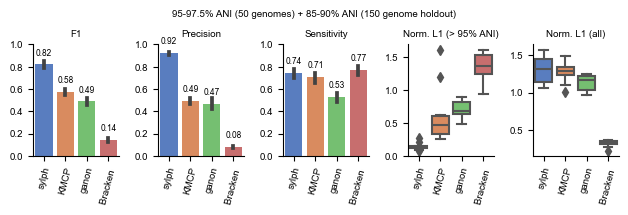

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = 1/2.54  # centimeters in inches\n",
cmap = sns.color_palette("muted")
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})

fig, axes = plt.subplots(1, 5, figsize=(16*cm, 5*cm), sharey=False)
plt.subplots_adjust(hspace=0.0)

# Define the test setups and metrics
test_setups = ["95-97.5% ANI (50 genomes) + 85-90% ANI (150 genome holdout)"] 
#               "95-97.5% ANI (200 genomes)",
#               "97.5-99.9% ANI (200 genomes)"]
metrics = ['f1', 'precision', 'sensitivity', 'l1_constrain', 'l1genus']

y_positions = [1, 0.65, 0.30]

# Loop through the test setups and metrics to fill the grid
for i, setup in enumerate(test_setups):
    if i == 0:
        methods = ['sylph', 'KMCP', 'ganon', 'Bracken ']
        stats_l = [sylph_stats, kmcp_stats, ganon_stats, kraken_stats]
    else:
        methods = ['sylph', 'KMCP', 'ganon', 'Bracken', 'MetaPhlAn4*']
        stats_l = [sylph_stats, kmcp_stats, ganon_stats, kraken_stats, metaphlan_stats]
    for j, metric in enumerate(metrics):
        if j == 4:
            stats_l = [[sylph_stats_all,[],[]],
                       [kmcp_stats_all,[],[]], 
                       [ganon_stats_all,[],[]],
                       [kraken_stats_all,[],[]]]
        ax = axes[j]
        
        # Extract the data for this subplot
        data_to_plot = []
        for k, method_stats in enumerate(stats_l):
            #print(method_stats[i])
            method_data = [x[metric] for x in method_stats[i]]
            data_to_plot.append(method_data)
        
        # Create the boxplot with smaller width
        if j < 3:
            sns.barplot(data=data_to_plot, ax=ax, palette="muted")
            ax.set_ylim([0,1])
        else:
            sns.boxplot(data=data_to_plot, ax=ax, palette="muted")
            
        # Add labels
        ax.set_xticklabels(methods)
        ax.set_ylabel(metric.capitalize())
        ax.set_ylabel("")
        ax.set_title(metric.capitalize(),fontsize=7)
        if j == 4:
            ax.set_title('Norm. L1 (all)', fontsize=7)
        if j == 3:
            ax.set_title('Norm. L1 (> 95% ANI)', fontsize=7)

        #if j == 2:
           # ax.set_title(test_setups[i], fontsize=7.0)
        
        # Remove the top and right borders
        sns.despine(ax=ax)
        ax.tick_params(axis='x', rotation=75)
        #if i != 2:
        #    ax.set_xticks([])
    for (k,ax) in enumerate(axes[:3]):
        for p in ax.patches:
            ax.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.065,),
                    ha='center', va='bottom',fontsize=6)
    # Add one title per row in the middle
    #fig.text(0.5, y_positions[i], setup, ha="center", va="center", fontsize=9)
fig.text(0.5, 1, test_setups[0], ha='center', va='bottom')
# Show the grid of plots
plt.tight_layout()
plt.savefig('figures/f2-ani_r89_benchmark.svg')
plt.show()

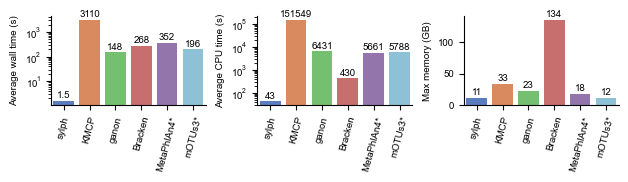

In [15]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize empty lists to store data
time_data = []
cpu_time_data = []
memory_data = []

plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})

# Function to read and parse benchmark data
def read_benchmark_data(filename, method, num_samples=1):
    with open(filename, 'r') as f:
        lines = f.readlines()
        headers = lines[0].strip().split('\t')
        values = lines[1].strip().split('\t')

        time_index = headers.index('s')
        cpu_time_index = headers.index('cpu_time')
        memory_index = headers.index('max_rss')

        time_data.append({'method': method, 'time': float(values[time_index])/num_samples})
        cpu_time_data.append({'method': method, 'cpu_time': float(values[cpu_time_index])/num_samples})
        memory_data.append({'method': method, 'memory': float(values[memory_index])/1000})

# Loop through each experiment and collect data
for exp in ['species90', 'species96', 'species98']:
    for method in [ 'kmcp', 'ganon', 'kraken', 'metaphlan', 'motus']:
        for iter_file in glob.glob(f'/mnt/disks/1tb/simulation_reads/benchmarks/{exp}/{exp}_*.{method}.benchmark'):
            read_benchmark_data(iter_file, method)

# Read sylph data (let's assume you have 30 samples for sylph)
read_benchmark_data('/mnt/disks/1tb/simulation_reads/benchmarks/sylph.benchmark', 'sylph', num_samples=30)

# Convert lists of dictionaries to DataFrames
time_df = pd.DataFrame(time_data)
cpu_time_df = pd.DataFrame(cpu_time_data)
memory_df = pd.DataFrame(memory_data)

method_to_label = {
    'ganon': 'ganon',
    'kmcp': 'KMCP',
    'kraken': 'Bracken',
    'sylph': 'sylph',
    'metaphlan': 'MetaPhlAn4*',
    'motus': 'mOTUs3*'
    
}


# Replace the method names in the DataFrames
time_df['method'] = time_df['method'].map(method_to_label)
cpu_time_df['method'] = cpu_time_df['method'].map(method_to_label)
memory_df['method'] = memory_df['method'].map(method_to_label)
# Create subplots

fig, axes = plt.subplots(1, 3, figsize=(16*cm, 5*cm))
p = sns.color_palette("muted")
palette = [p[0],p[1],p[2],p[3],p[4],p[9]]
ordered_labels = ['sylph',  'KMCP', 'ganon','Bracken', 'MetaPhlAn4*', 'mOTUs3*']
# Plot the wall time, CPU time and memory
ax1 = sns.barplot(y='time', x='method', log=True, data=time_df, estimator=lambda x: sum(x)/len(x), ax=axes[0], ci=False, palette=palette, order=ordered_labels)
ax2 = sns.barplot(y='cpu_time', x='method', log=True,  data=cpu_time_df, estimator=lambda x: sum(x)/len(x), ax=axes[1], ci=False, palette=palette, order=ordered_labels)
ax3 = sns.barplot(x='method', y='memory', data=memory_df, estimator=max, ax=axes[2], palette=palette, order=ordered_labels, ci=False)

ax1.set(xlabel='', ylabel='Average wall time (s)')
ax2.set(xlabel='', ylabel='Average CPU time (s)')
ax3.set(xlabel='', ylabel='Max memory (GB)')

# Add titles and remove top and right borders
titles = ['Average Wall Time (s)', 'Average CPU Time (s)', 'Max Memory (RSS)']
for ax, title in zip(axes, titles):
    #ax.set_title(title)
    sns.despine(ax=ax)

# Annotate bars with integers
for (k,ax) in enumerate(axes):
    for p in ax.patches:
        v = round(p.get_height())
        if p.get_height() < 10:
            v = round(p.get_height(),1)
        if k == 2:
            ax.annotate(f'{v}', (p.get_x() + p.get_width() / 2., p.get_height() + 2 ),
                    ha='center', va='bottom')
        else:
            ax.annotate(f'{v}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.1 ),
                    ha='center', va='bottom')
    ax.tick_params(axis='x', rotation=75)

#plt.suptitle('Performance Metrics Across All Methods, Samples, and Experiments')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures/f2-ani_profile_benchmark_times.svg')
plt.show()

In [19]:
def truth_strat(file_path, spec_to_metadata, ref_to_spec, spec90 = False):
    taxonomic_data = dict()
    results = []
    with open(file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for row in csv_reader:
            spl = row
            gn = spl[-1].strip().split('/')[-1].split('_genomic')[0][3:]
            
            spec = ref_to_spec[gn]
            seq_abund = float(spl[1])
            size = float(spec_to_metadata[spec[1]]['genome_size'])
            data = tax_result(spec[1], spec[0], size, seq_abund)
            if spec90:
                if len(results) >= 50:
                    break
            results.append(data)
    total_cov = 0
    total_seq = 0
    for r in results:
        total_cov += r.abund * r.seq_abund
        total_seq += r.seq_abund
    for r in results:
        r.abund = r.abund * r.seq_abund / total_cov
        #r.seq_abund = r.seq_abund / total_seq
        if r.species in taxonomic_data:
            #print(r.species)
            taxonomic_data[r.species].seq_abund += r.seq_abund 
            taxonomic_data[r.species].abund += r.abund 
        else:
            taxonomic_data[r.species] = r
    return taxonomic_data

def truth_detect(truth, stats):
    res = []
    for species in stats.keys():
        if species not in truth:
            res.append([stats[species].seq_abund, 0])
        else:
         #   print('succ')
            res.append([stats[species].seq_abund, 1])
            
    return res


def truth_sense(truth, stats):
    res = []
    for species in truth.keys():
        if species not in stats:
            res.append([truth[species].seq_abund, 0])
        else:
         #   print('succ')
            res.append([truth[species].seq_abund, 1])
            
    return res
    
sylph_results,sylph_gen_results = read_sylph('/mnt/disks/1tb/simulation_reads/sylph_out_strat/sylph_output.tsv', ref_to_spec)
anis = [95,96,97,98,99]
strat_stats = []
its = range(1,10)

for (i,diff) in enumerate(anis):
    for it in its:
        files = [' ', f'/mnt/disks/1tb/simulation_reads/strat/species{diff}_{it}.tsv',
               'sylph',
             f'/mnt/disks/1tb/simulation_reads/kmcp_out_strat/strat/species{diff}_{it}.kmcp.profile',
             f'/mnt/disks/1tb/simulation_reads/ganon_out_strat/strat/species{diff}_{it}.ganon.tre',
            f'/mnt/disks/1tb/simulation_reads/kraken_out_strat/strat/species{diff}_{it}_bracken_species.kreport',
            f'/mnt/disks/1tb/simulation_reads/metaphlan_out_strat/strat/species{diff}_{it}.metaphlan.gtdb',
              ]

        truth_data = truth_strat(files[1], spec_to_metadata,ref_to_spec)
        results = files[2:]
        
        rg = "ref_genomes/"
        out = ""
        print(it,diff)
        for result in results:
            if 'ganon' in result:
                results,gen_results = read_ganon_file(result, species_name_to_spec, spec_to_metadata)
                out = f"{rg}{diff}_{it}.ganon.sh"
            elif 'sylph' in result:
                gen_results = sylph_gen_results[(diff,it)]
                results = sylph_results[(diff,it)]
                out = f"{rg}{diff}_{it}.sylph.sh"
            elif 'kraken' in result:
                results,gen_results = read_kraken_file(result, species_name_to_spec, spec_to_metadata, kraken_cutoff)
                out = f"{rg}{diff}_{it}.kraken.sh"
                #compare_to_truth(results, truth_data)
                #results = read_kraken_file(result, species_name_to_spec, spec_to_metadata, 0.01 / 100)
            elif 'kmcp' in result:
                out = f"{rg}{diff}_{it}.kmcp.sh"
                results,gen_results = read_kmcp_file(result, species_name_to_spec, spec_to_metadata)
            elif 'metaphlan' in result:
                if diff == 90:
                    continue
                out = f"{rg}{diff}_{it}.metaphlan.sh"
                results,gen_results = read_metaphlan(result, spec_to_metadata, r207_to_r89)

            debug = False
            #print(results)
            stats = compare_to_truth(results, gen_results, truth_data, result, debug)
            detect = truth_detect(truth_data, results)
            sense = truth_sense(truth_data, results)
            meth = ""
            ANI = diff
            if 'sylph' in result:
                method= "sylph"
            elif 'kmcp' in result:
                method = "KMCP"
            elif 'ganon' in result:
                method = "ganon"
            elif 'kraken' in result:
                method ='Bracken\n0.01% cutoff'
            elif 'metaphlan' in result:
                method = "MetaPhlAn4*"
            else:
                continue
            #print(stats)
            strat_stats.append({"method":method, "ani": f"[{ANI},{ANI+1})", "Precision" : stats['precision'], "Sensitivity": stats['sensitivity'], "detect":detect, "sense": sense})


1 95
---------------    sylph
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp
0.7272727272727273 0.6618011502728104 0.4777413165904677 0.64 0.8421052631578947 38 32 6
---------------    /mnt/disks/1tb/simulation_reads/kmcp_out_strat/strat/species95_1.kmcp.profile
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp
0.5925925925925926 0.6103530828947583 0.3009586772860443 0.64 0.5517241379310345 58 32 26
---------------    /mnt/disks/1tb/simulation_reads/ganon_out_strat/strat/species95_1.ganon.tre
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp
0.4533333333333333 1.065937844519868 0.5787594217311648 0.68 0.33999999999999997 100 34 66
---------------    /mnt/disks/1tb/simulation_reads/kraken_out_strat/strat/species95_1_bracken_species.kreport
F1, l1 seq, l1 gen, sens, prec, number_of_predicted, num correct, num fp
0.292063492063492 0.7775248255055447 0.11115888873328206 0.92 0.17358490566037732 265 46 219
-------------

                  method         ab  det
0  Bracken\n0.01% cutoff   0.100000    1
1  Bracken\n0.01% cutoff   1.000000    1
2  Bracken\n0.01% cutoff  10.000000    1
3  Bracken\n0.01% cutoff   1.000000    1
4  Bracken\n0.01% cutoff   0.316228    1
method                 ani     
Bracken\n0.01% cutoff  [95,96)     0.176424
                       [96,97)     0.206098
                       [97,98)     0.282578
                       [98,99)     0.352381
                       [99,100)    0.482502
KMCP                   [95,96)     0.604686
                       [96,97)     0.623740
                       [97,98)     0.807563
                       [98,99)     0.867910
                       [99,100)    0.932299
MetaPhlAn4*            [95,96)     0.827735
                       [96,97)     0.793613
                       [97,98)     0.904537
                       [98,99)     0.918692
                       [99,100)    0.953766
ganon                  [95,96)     0.388572
                  

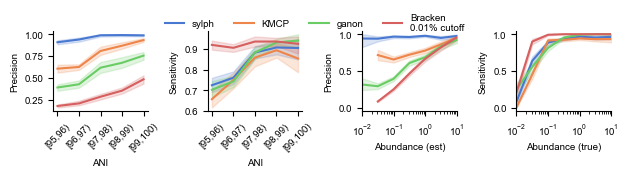

In [21]:
import pandas as pd
df = pd.DataFrame(strat_stats)
from collections import defaultdict
p = sns.color_palette("muted")
import warnings
warnings.filterwarnings('ignore')
import matplotlib 
#df.apply(lambda x: np.round(np.log(x['detect'][0]) * 2)/2, axis=1)
detects = defaultdict(list)
senses = defaultdict(list)
for method,x in df.groupby(['method','ani']):
#for method,x in df.groupby(['method']):
    #print(method)
    detects[tuple(method)] += list(x['detect'])
    senses[tuple(method)] += list(x['sense'])
    #print(x['detect'])
det_95 = [] 
det_99 = []
det = []
sense = []
ordered_labels = ['sylph',  'KMCP', 'ganon','Bracken\n0.01% cutoff']#, 'MetaPhlAn4*']

for method, d in detects.items():
    for res in d:
        for thing in res:
            det.append({"method":method[0], "ab" : round(np.log10(thing[0] * 100) * 2)/2, "det" : thing[1]})
            #print(thing)       
            if '[99' in method[1]:
                det_99.append({"method":method[0], "ab" : round(np.log10(thing[0] * 100) * 2)/2, "det" : thing[1]})
            if '[95' in method[1]:
                det_95.append({"method":method[0], "ab" : round(np.log10(thing[0] * 100) * 2)/2, "det" : thing[1]})

for method, d in senses.items():
    for res in d:
        for thing in res:
            sense.append({"method":method[0], "ab" : round(np.log10(thing[0] * 100) * 2)/2, "det" : thing[1]})
                
       # print(res)
        #res[0] = np.round(np.log(res[0]) * 2) / 2
   # d = np.array(d)

df_det_95 = pd.DataFrame(det_95)
df_det_99 = pd.DataFrame(det_99)
df_det = pd.DataFrame(det)
df_sense = pd.DataFrame(sense)

df_det['ab'] = df_det['ab'].apply(lambda x: 10**x)
df_sense['ab'] = df_sense['ab'].apply(lambda x: 10**x)

print(df_sense.head())
fig, axes = plt.subplots(1, 4, figsize=(16*cm, 4*cm), sharey=False)
g = sns.lineplot(x='ani',y='Precision',data=df,hue='method',ax=axes[0], palette = p,hue_order=ordered_labels)
sns.lineplot(x='ani',y='Sensitivity',data=df,hue='method',ax=axes[1], palette = p,hue_order=ordered_labels)
sns.lineplot(x ='ab', y = 'det', data = df_det, ax = axes[2], hue='method', hue_order=ordered_labels, palette = p)
sns.lineplot(x ='ab', y = 'det', data = df_sense, ax = axes[3], hue='method', hue_order=ordered_labels, palette = p)

print(df.groupby(['method','ani'])['Precision'].mean())

#sns.lineplot(x ='ab', y = 'det', data = df_det_99, ax = axes[2], hue='method', hue_order=ordered_labels, ci = False)

for l,ax in enumerate(axes):
    ax.legend([],[], frameon=False)
    if l < 2:
        ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("ANI")
    sns.despine(ax=ax)
axes[2].set_xlabel("Abundance (est)")
axes[2].set_ylabel("Precision")
axes[2].set_xscale('log')
axes[2].set_xlim([0.01,10])
axes[3].set_xlabel("Abundance (true)")
axes[3].set_ylabel("Sensitivity")
axes[3].set_xscale('log')
#axes[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#axes[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes[3].set_xlim([0.01,10])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False,bbox_to_anchor=(0.5,1.1))
if 'MetaPhlAn4*' in ordered_labels:
    print('metaphlan')
    plt.savefig("supp_figs/supp-strat_plot_metaphlan.svg")
else:
    plt.savefig("figures/f2-stratified_plots.svg")

#plt.show()
#plt.figure(figsize=(3,3))
#sns.lineplot(x ='ab', y = 'det', data = df_det_95,  hue='method', hue_order=ordered_labels)
#sns.lineplot(x ='ab', y = 'det', data = df_det_99,  hue='method', hue_order=ordered_labels)



/tmp/ipykernel_8786/3286772668.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["F1 score"] = pd.to_numeric(df["F1 score"])
/tmp/ipykernel_8786/3286772668.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["F1 score"] = pd.to_numeric(df["F1 score"])
/tmp/ipykernel_8786/3286772668.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

method
Bracken        0.501590
KMCP           0.266014
MetaPhlAn2     0.404580
MetaPhlAn4*    0.368572
mOTUs v2.5     0.420822
mOTUs v3*      0.338229
sylph          0.248273
Name: L1 norm error, dtype: float64
method
Bracken        0.373480
KMCP           0.157452
MetaPhlAn2     0.328250
MetaPhlAn4*    0.242639
mOTUs v2.5     0.158796
mOTUs v3*      0.111181
sylph          0.115113
Name: L1 norm error, dtype: float64


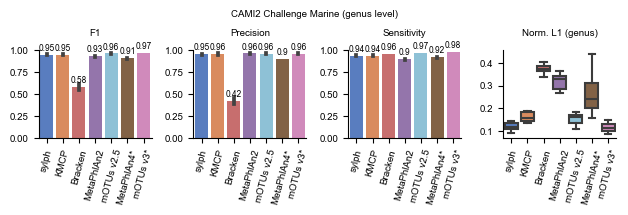

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
cm = 1/2.54
cm = 1/2.54  # centimeters in inches\n",
    ##Change this to get a bigger figure. \n",
cmap = sns.color_palette("muted")
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})
genus_plot = True
cust_plot = True

#sylph_cami = pd.read_csv("sylph_opal/by_tool/sylph.profile.tsv",sep='\t')
sylph_cami = pd.read_csv("sylph_marmg_v0.5_opal/by_tool/sylph_marmg_v0.5.profile.tsv",sep='\t')

bracken_cami = pd.read_csv("rerun_opal/by_tool/marmgCAMI2_short_read_sample_0-9.bracken_2.2.profile.tsv",sep='\t')
metaphlan_cami = pd.read_csv("rerun_opal/by_tool/marmgCAMI2_short_read_sample_0-9.metaphlan2_2.9.22.profile.tsv",sep='\t')
kmcp_cami = pd.read_csv("kmcp_m3_test/by_tool/kmcp-se-r1.c-m3.profile.tsv",sep='\t')
motus_cami = pd.read_csv("rerun_opal/by_tool/marmgCAMI2_short_read_sample_0-9.motus_2.5.1.profile.tsv",sep='\t')
metaphlan4_cust = pd.read_csv("metaphlan4_motus_opal/by_tool/metaphlan_marine_all.profile.tsv",sep='\t')
motus3_cust = pd.read_csv("metaphlan4_motus_opal/by_tool/motus_ocean_all.profile.tsv",sep='\t')

if cust_plot:
    df_a = pd.concat([sylph_cami.assign(method='sylph'), 
                    kmcp_cami.assign(method='KMCP'),
                bracken_cami.assign(method='Bracken'), 
               metaphlan_cami.assign(method='MetaPhlAn2'),
               motus_cami.assign(method='mOTUs v2.5'),
                metaphlan4_cust.assign(method='MetaPhlAn4*'),
                 motus3_cust.assign(method='mOTUs v3*'),
                     ])
elif genus_plot:
    df_a = pd.concat([sylph_cami.assign(method='sylph'), 
                        kmcp_cami.assign(method='KMCP'),
                    bracken_cami.assign(method='Bracken'), 
                   metaphlan_cami.assign(method='MetaPhlAn2'),
                   motus_cami.assign(method='mOTUs v2.5'),])
else:
    df_a = pd.concat([sylph_cami.assign(method='sylph'), 
                        kmcp_cami.assign(method='KMCP'),
                    bracken_cami.assign(method='Bracken'), 
                   metaphlan_cami.assign(method='MetaPhlAn2'),
                   motus_cami.assign(method='mOTUs v2.5'),])   

pc = sns.color_palette("muted")
df = df_a.loc[df_a['rank'] == 'species']
df["F1 score"] = pd.to_numeric(df["F1 score"])
df["F1 score"] = pd.to_numeric(df["F1 score"])
df["L1 norm error"] = pd.to_numeric(df["L1 norm error"])
df_g = df_a.loc[df_a['rank'] == 'genus']
df_g["L1 norm error"] = pd.to_numeric(df_g["L1 norm error"])
df_g["F1 score"] = pd.to_numeric(df_g["F1 score"])
df_g["Purity"] = pd.to_numeric(df_g["Purity"])

if genus_plot:
    p = [pc[0], pc[1], pc[3], pc[4], pc[9]]
    if cust_plot:
        p.append(pc[5])
        p.append(pc[6])
    fig, axes = plt.subplots(1, 4, figsize=(16*5/5*cm, 5*cm), sharey=False)
    sns.barplot(x = 'method', y = 'F1 score', data = df_g, ax = axes[0], palette = p)
    sns.barplot(x = 'method', y = 'Purity', data = df_g, ax = axes[1], palette = p)
    sns.barplot(x = 'method', y = 'Completeness', data = df_g, ax = axes[2], palette = p)
    sns.boxplot(x = 'method', y = 'L1 norm error', data = df_g, ax = axes[3], palette = p)
    ylabels = ["F1", "Precision", "Sensitivity", "Norm. L1 (genus)"]
else:
    p = [pc[0], pc[1], pc[3], pc[4], pc[9]]
    if cust_plot:
        p.append(pc[5])
        p.append(pc[6])
    if cust_plot:
        num_plots = 4
    else:
        num_plots = 5
    fig, axes = plt.subplots(1, num_plots, figsize=(16*cm, 5*cm), sharey=False)
    sns.barplot(x = 'method', y = 'F1 score', data = df, ax = axes[0], palette = p)
    sns.barplot(x = 'method', y = 'Purity', data = df, ax = axes[1], palette = p)
    sns.barplot(x = 'method', y = 'Completeness', data = df, ax = axes[2], palette = p)
    sns.boxplot(x = 'method', y = 'L1 norm error', data = df, ax = axes[3], palette = p)
    if not cust_plot:
        sns.boxplot(x = 'method', y = 'L1 norm error', data = df_g, ax = axes[4], palette = p)
    ylabels = ["F1", "Precision", "Sensitivity", "Norm. L1 (species)", "Norm. L1 (genus)"]
for i,ax in enumerate(axes):
    if i < 3:
        ax.set_ylim([0,1])
    ax.set_xlabel("")
    sns.despine(ax=ax)
    #ax.set_ylabel(ylabels[i])
    ax.set_ylabel("")
    ax.set_title(ylabels[i], fontsize=7,pad=10)
    ax.tick_params(axis='x', rotation=75)

print(df.groupby('method')['L1 norm error'].median())
print(df_g.groupby('method')['L1 norm error'].median())

#fig, axes = plt.subplots(1, 3, figsize=(18*cm, 5*cm), sharey=False)
#df = df_a.loc[df_a['rank'] == 'genus']
#df["F1 score"] = pd.to_numeric(df["F1 score"])
#df["F1 score"] = pd.to_numeric(df["F1 score"])
#df["L1 norm error"] = pd.to_numeric(df["L1 norm error"])

#sns.barplot(x = 'method', y = 'F1 score', data = df, ax = axes[0], palette = p)

#sns.barplot(x = 'method', y = 'Purity', data = df, ax = axes[1], palette = p)

#sns.boxplot(x = 'method', y = 'L1 norm error', data = df, ax = axes[2], palette = p)
for (k,ax) in enumerate(axes[0:3]):
    for p in ax.patches:
        ax.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.025 ),
                ha='center', va='bottom',fontsize=6)
if genus_plot:
    title = 'CAMI2 Challenge Marine (genus level)'
    fig.text(0.5, 1, title, ha='center', va='bottom')
else:
    title = 'CAMI2 Challenge Marine (species level)'
    fig.text(0.5, 1, title, ha='center', va='bottom')
#axes[2].set_title("CAMI2 Challenge Marine (species level)",fontsize=7)
if cust_plot and genus_plot:
    plt.savefig("supp_figs/cami2-cust-genus.svg")
elif cust_plot and not genus_plot:
    plt.savefig("supp_figs/cami2-cust-species.svg")
elif genus_plot:
    plt.savefig("supp_figs/f2-cami2_marine_genus.svg")
else:
    plt.savefig("figures/f2-cami2_marine.svg")

/tmp/ipykernel_8786/4257703384.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["F1 score"] = pd.to_numeric(df["F1 score"])
/tmp/ipykernel_8786/4257703384.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["F1 score"] = pd.to_numeric(df["F1 score"])
/tmp/ipykernel_8786/4257703384.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

method
Bracken        0.494529
MetaPhlAn2     0.227076
MetaPhlAn4*    0.137821
mOTUs v2.5     1.809849
mOTUs v3*      0.185368
sylph          0.164327
Name: L1 norm error, dtype: float64
method
Bracken        0.457320
MetaPhlAn2     0.123145
MetaPhlAn4*    0.093097
mOTUs v2.5     0.878016
mOTUs v3*      0.122860
sylph          0.139049
Name: L1 norm error, dtype: float64


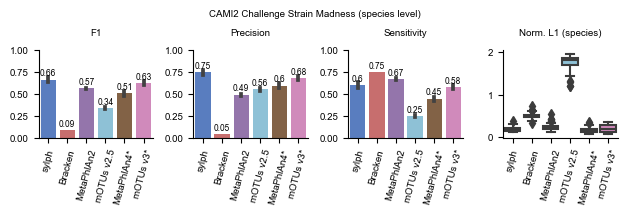

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
cm = 1/2.54
cm = 1/2.54  # centimeters in inches\n",
    ##Change this to get a bigger figure. \n",
cmap = sns.color_palette("muted")
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})
genus_plot = False
cust_plot = True

#sylph_cami = pd.read_csv("strmg_sylph_opal/by_tool/strmg_sylph.profile.tsv",sep='\t')
sylph_cami = pd.read_csv("sylph_strmg_v0.5_opal//by_tool/strmg_sylph_v0.5.profile.tsv",sep='\t')
bracken_cami = pd.read_csv("rerun_strmg_opal/by_tool/strmgCAMI2_short_read_sample_0-99.bracken_2.2.profile.tsv",sep='\t')
metaphlan_cami = pd.read_csv("rerun_strmg_opal/by_tool/strmgCAMI2_short_read_sample_0-99.metaphlan2_2.9.22.profile.tsv",sep='\t')
#kmcp_cami = pd.read_csv("kmcp_m3_test/by_tool/kmcp-se-r1.c-m3.profile.tsv",sep='\t')
motus_cami = pd.read_csv("rerun_strmg_opal/by_tool/strmgCAMI2_short_read_sample_0-99.motus_2.5.1_default_norm.profile.tsv",sep='\t')
metaphlan4_cust = pd.read_csv("meta_motus_strmg_opal/by_tool/metaphlan_strain.profile.tsv",sep='\t')
motus3_cust = pd.read_csv("meta_motus_strmg_opal/by_tool/motus_strain.profile.tsv",sep='\t')

if cust_plot:
    df_a = pd.concat([sylph_cami.assign(method='sylph'), 
              #      kmcp_cami.assign(method='KMCP'),
                bracken_cami.assign(method='Bracken'), 
               metaphlan_cami.assign(method='MetaPhlAn2'),
               motus_cami.assign(method='mOTUs v2.5'),
                metaphlan4_cust.assign(method='MetaPhlAn4*'),
                 motus3_cust.assign(method='mOTUs v3*'),
                     ])
elif genus_plot:
    df_a = pd.concat([sylph_cami.assign(method='sylph'), 
                #        kmcp_cami.assign(method='KMCP'),
                    bracken_cami.assign(method='Bracken'), 
                   metaphlan_cami.assign(method='MetaPhlAn2'),
                   motus_cami.assign(method='mOTUs v2.5'),])
else:
    df_a = pd.concat([sylph_cami.assign(method='sylph'), 
                    #    kmcp_cami.assign(method='KMCP'),
                    bracken_cami.assign(method='Bracken'), 
                   metaphlan_cami.assign(method='MetaPhlAn2'),
                   motus_cami.assign(method='mOTUs v2.5'),])   

pc = sns.color_palette("muted")
df = df_a.loc[df_a['rank'] == 'species']
df["F1 score"] = pd.to_numeric(df["F1 score"])
df["F1 score"] = pd.to_numeric(df["F1 score"])
df["L1 norm error"] = pd.to_numeric(df["L1 norm error"])
df_g = df_a.loc[df_a['rank'] == 'genus']
df_g["L1 norm error"] = pd.to_numeric(df_g["L1 norm error"])
df_g["F1 score"] = pd.to_numeric(df_g["F1 score"])
df_g["Purity"] = pd.to_numeric(df_g["Purity"])

if genus_plot:
    p = [pc[0], pc[3], pc[4], pc[9]]
    if cust_plot:
        p.append(pc[5])
        p.append(pc[6])
    fig, axes = plt.subplots(1, 4, figsize=(16*5/5*cm, 5*cm), sharey=False)
    sns.barplot(x = 'method', y = 'F1 score', data = df_g, ax = axes[0], palette = p)
    sns.barplot(x = 'method', y = 'Purity', data = df_g, ax = axes[1], palette = p)
    sns.barplot(x = 'method', y = 'Completeness', data = df_g, ax = axes[2], palette = p)
    sns.boxplot(x = 'method', y = 'L1 norm error', data = df_g, ax = axes[3], palette = p)
    ylabels = ["F1", "Precision", "Sensitivity", "Norm. L1 (genus)"]
else:
    p = [pc[0], pc[3], pc[4], pc[9]]
    if cust_plot:
        p.append(pc[5])
        p.append(pc[6])
    if cust_plot:
        num_plots = 4
    else:
        num_plots = 5
    fig, axes = plt.subplots(1, num_plots, figsize=(16*cm, 5*cm), sharey=False)
    sns.barplot(x = 'method', y = 'F1 score', data = df, ax = axes[0], palette = p)
    sns.barplot(x = 'method', y = 'Purity', data = df, ax = axes[1], palette = p)
    sns.barplot(x = 'method', y = 'Completeness', data = df, ax = axes[2], palette = p)
    r = sns.boxplot(x = 'method', y = 'L1 norm error', data = df, ax = axes[3], palette = p)
    #r.set(yscale='log')
    if not cust_plot:
        sns.boxplot(x = 'method', y = 'L1 norm error', data = df_g, ax = axes[4], palette = p)
    ylabels = ["F1", "Precision", "Sensitivity", "Norm. L1 (species)", "Norm. L1 (genus)"]

print(df.groupby('method')['L1 norm error'].median())
print(df_g.groupby('method')['L1 norm error'].median())

for i,ax in enumerate(axes):
    if i < 3:
        ax.set_ylim([0,1])
    ax.set_xlabel("")
    sns.despine(ax=ax)
    #ax.set_ylabel(ylabels[i])
    ax.set_ylabel("")
    ax.set_title(ylabels[i], fontsize=7,pad=10)
    ax.tick_params(axis='x', rotation=75)

#fig, axes = plt.subplots(1, 3, figsize=(18*cm, 5*cm), sharey=False)
#df = df_a.loc[df_a['rank'] == 'genus']
#df["F1 score"] = pd.to_numeric(df["F1 score"])
#df["F1 score"] = pd.to_numeric(df["F1 score"])
#df["L1 norm error"] = pd.to_numeric(df["L1 norm error"])

#sns.barplot(x = 'method', y = 'F1 score', data = df, ax = axes[0], palette = p)

#sns.barplot(x = 'method', y = 'Purity', data = df, ax = axes[1], palette = p)

#sns.boxplot(x = 'method', y = 'L1 norm error', data = df, ax = axes[2], palette = p)
for (k,ax) in enumerate(axes[0:3]):
    for p in ax.patches:
        if p.get_height() > 0.99:
            ax.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.0 ),
                ha='center', va='bottom',fontsize=6) 
        else:
            ax.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.02 ),
                ha='center', va='bottom',fontsize=6)
if genus_plot:
    title = 'CAMI2 Challenge Strain Madness (genus level)'
    fig.text(0.5, 1, title, ha='center', va='bottom')
else:
    title = 'CAMI2 Challenge Strain Madness (species level)'
    fig.text(0.5, 1, title, ha='center', va='bottom')
#axes[2].set_title("CAMI2 Challenge Marine (species level)",fontsize=7)
if cust_plot and genus_plot:
    plt.savefig("supp_figs/cami2-strmg-cust-genus.svg")
elif cust_plot and not genus_plot:
    plt.savefig("supp_figs/cami2-strmg-cust-species.svg")
elif genus_plot:
    plt.savefig("supp_figs/f2-cami2_strmng_genus.svg")
else:
    plt.savefig("figures/f2-cami2_strmng.svg")

# Meslier et al MOCK2 real profiling

median ani r89 100.0
s__Escherichia flexneri tax_result(species='s__Escherichia flexneri', genus='', abund=0, seq_abund=0)
s__Helicobacter pylori tax_result(species='s__Helicobacter pylori', genus='', abund=0, seq_abund=0)
s__Pyrobaculum arsenaticum tax_result(species='s__Pyrobaculum arsenaticum', genus='', abund=0, seq_abund=0)
s__Geobacter_A bemidjiensis tax_result(species='s__Geobacter_A bemidjiensis', genus='', abund=0, seq_abund=0)
s__Haloferax volcanii tax_result(species='s__Haloferax volcanii', genus='', abund=0, seq_abund=0)
s__Desulfitobacterium dehalogenans tax_result(species='s__Desulfitobacterium dehalogenans', genus='', abund=0, seq_abund=0)
s__Desulfovibrio_A vulgaris tax_result(species='s__Desulfovibrio_A vulgaris', genus='', abund=0, seq_abund=0)
s__Pseudodesulfovibrio desulfuricans tax_result(species='s__Pseudodesulfovibrio desulfuricans', genus='', abund=0, seq_abund=0)
tax_result(species='s__Stenotrophomonas maltophilia_S', genus='g__Stenotrophomonas', abund=0.000219

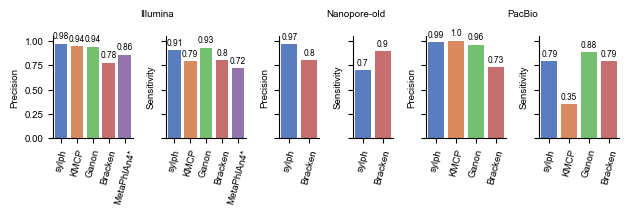

In [27]:
def get_truth_skani(truth_file, ref_to_spec):
    truth = {}
    anis = []
    with open(truth_file, 'r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')
        for row in csv_reader:
            ref = row['Ref_file'].split('/')[-1]
            ref = ref.split('_genomic')[0][3:]
            spec = ref_to_spec[ref][1]
            #print(spec)
            truth[spec] = tax_result(spec, "", 0, 0)
            anis.append(float(row['ANI']))
    print('median ani r89', np.median(anis))
    return truth
            

def read_sylph_meslier(file_path, ref_to_spec):
    sample_to_taxonomic_data = dict()
    sample_to_genus_data = dict()
    with open(file_path, 'r') as f:
        csv_reader = csv.DictReader(f, delimiter='\t')
        for row in csv_reader:
            spl = row
            query = row['Sample_file']
            exp = ""
            if 'illu' in query:
                exp = 'illu'
            elif 'nano' in query:
                exp = 'nano'
            elif 'pac' in query:
                exp = 'pac'
            else:
                print("exp not found", query)
            if exp in sample_to_taxonomic_data:
                taxonomic_data = sample_to_taxonomic_data[exp]
            else:
                taxonomic_data = {}
                sample_to_taxonomic_data[exp] = taxonomic_data
            if 'Query_file' in row:
                ref = row['Query_file'].split('/')[-1].split('_genomic')[0][3:]
            else:
                ref = row['Genome_file'].split('/')[-1].split('_genomic')[0][3:]
            spec = ref_to_spec[ref]
            r = tax_result(spec[1],spec[0], float(row['Taxonomic_abundance'])/100, float(row['Sequence_abundance'])/100)
            taxonomic_data[spec[1]] = r
    for key,tax_data in sample_to_taxonomic_data.items():
        gen_data = {}
        for thing in tax_data.values():
            if thing.genus not in gen_data:
                gen_data[thing.genus] = gen_abund(thing.genus, thing.seq_abund)
            else:
                gen_data[thing.genus].seq_abund += thing.seq_abund
        sample_to_genus_data[key] = gen_data
    return (sample_to_taxonomic_data, sample_to_genus_data)

(sylph_results,sylph_gen_results) = read_sylph_meslier('/mnt/disks/1tb/chng_meslier_simulated/sylph_out_meslier/sylph_output.tsv', ref_to_spec)
#(sylph_results,sylph_gen_results) = read_sylph('/mnt/disks/1tb/simulation_reads/sylph_results.tsv', ref_to_spec)

sylph_stats = dict()
kmcp_stats = dict()
ganon_stats = dict()
kraken_stats = dict()
metaphlan_stats = dict()
all_stats = []
exps = ['illu','nano','pac']

truth = f'/mnt/disks/1tb/chng_meslier_simulated/meslier_mock2-on_r89'
truth_data = get_truth_skani(truth,ref_to_spec)

for (i,exp) in enumerate(exps):
    if 'illu' == exp: 
        files = ['sylph',
             f'/mnt/disks/1tb/chng_meslier_simulated/kmcp_out_meslier/{exp}.kmcp.profile',
             f'/mnt/disks/1tb/chng_meslier_simulated/ganon_out_meslier/{exp}.ganon.tre',
            f'/mnt/disks/1tb/chng_meslier_simulated/kraken_out_meslier/{exp}_bracken_species.kreport',
            f'/mnt/disks/1tb/chng_meslier_simulated/metaphlan_out_meslier/{exp}.metaphlan.gtdb',
                ]
    elif 'nano' == exp:
        files = ['sylph',
             #f'/mnt/disks/1tb/chng_meslier_simulated/kmcp_out_meslier/{exp}.kmcp.profile',
            #f'/mnt/disks/1tb/chng_meslier_simulated/ganon_out_meslier/{exp}.ganon.tre',
            f'/mnt/disks/1tb/chng_meslier_simulated/kraken_out_meslier/{exp}_bracken_species.kreport',
                ]  
    else:
        files = ['sylph',
             f'/mnt/disks/1tb/chng_meslier_simulated/kmcp_out_meslier/{exp}.kmcp.profile',
             f'/mnt/disks/1tb/chng_meslier_simulated/ganon_out_meslier/{exp}.ganon.tre',
            f'/mnt/disks/1tb/chng_meslier_simulated/kraken_out_meslier/{exp}_bracken_species.kreport',
                ]  
    for result in files:
        gen_results = dict()
        #print(results)
        if 'ganon' in result:
            (results, gen_results) = read_ganon_file(result, species_name_to_spec, spec_to_metadata)
        elif 'sylph' in result:
            results = sylph_results[exp]
            #gen_results = sylph_gen_results[exp]
        elif 'kraken' in result:
            (results,gen_results) = read_kraken_file(result, species_name_to_spec, spec_to_metadata, 0.01)
        elif 'kmcp' in result:
            (results,gen_results) = read_kmcp_file(result, species_name_to_spec, spec_to_metadata)
        elif 'metaphlan' in result:
            (results,gen_results) = read_metaphlan(result, spec_to_metadata, r207_to_r89)

        debug = False
        if 'metaphlan' in result or 'sylph' in result:
            debug = True
        stats = compare_to_truth(results, gen_results, truth_data, result, debug)
        all_stats.append((stats,exp,result))

    for stats,exp,result in all_stats:
        if 'sylph' in result:
            sylph_stats[exp] = stats
        if 'kmcp' in result:
            kmcp_stats[exp] = stats
        if 'ganon' in result:
            ganon_stats[exp] = stats
        if 'kraken' in result:
            kraken_stats[exp] = stats
        if 'metaphlan' in result:
            metaphlan_stats[exp] = stats

cm = 1/2.54  # centimeters in inches\n",
    ##Change this to get a bigger figure. \n",
cmap = sns.color_palette("muted")
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})

titles = ['Illumina','Illumina','Nanopore-old','Nanopore-old','PacBio', 'PacBio']
fig, axes = plt.subplots(1, 6, figsize=(16* cm, 5 * cm), sharey=True,gridspec_kw={'width_ratios': [4,4,2,2,4,4,]})
palette = sns.color_palette("muted")
#metric = 'precision'
for (i, exp) in enumerate(['illu', 'illu', 'nano', 'nano', 'pac', 'pac']):
    if i %2 == 0:
        metric = 'precision'
    else:
        metric = 'sensitivity'
    if exp == 'illu':
        ordered_labels = ['sylph',  'KMCP', 'Ganon', 'Bracken', 'MetaPhlAn4*']
        data = [[sylph_stats[exp][metric]], 
                [kmcp_stats[exp][metric]],
                [ganon_stats[exp][metric]],
                [kraken_stats[exp][metric]],
                [metaphlan_stats[exp][metric]]]
        c = [cmap[0], cmap[1], cmap[2], cmap[3], cmap[4]]
    elif exp == 'pac':
        ordered_labels = ['sylph', 'KMCP', 'Ganon', 'Bracken']
        data = [[sylph_stats[exp][metric]], [kmcp_stats[exp][metric]], [ganon_stats[exp][metric]], [kraken_stats[exp][metric]]]
        c = [cmap[0], cmap[1], cmap[2], cmap[3]]
    elif exp == 'nano':
        ordered_labels = ['sylph', 'Bracken']
        data = [[sylph_stats[exp][metric]], [kraken_stats[exp][metric]]]
        c = [cmap[0], cmap[3]]
    ax = sns.barplot(data = data, ax = axes[i], palette=c)
    ax.set_xticklabels(ordered_labels)
    ax.set_ylabel(metric.capitalize())
    #ax.set_title(titles[i])

    #ax.set_title(test_setups[i], fontsize=7)
    
    # Remove the top and right borders
    sns.despine(ax=ax)
    ax.tick_params(axis='x', rotation=75)

# Add this code to annotate with common titles
group_titles = ['Illumina', 'Nanopore-old', 'PacBio']
group_title_positions = [0.25, 0.565, 0.83]  # The x-position for each group title; adjust as needed
for (k,ax) in enumerate(axes):
    for p in ax.patches:
        ax.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.03 ),
                ha='center', va='bottom',fontsize=6)
for title, pos in zip(group_titles, group_title_positions):
    fig.text(pos, 1.00, title, ha='center', va='bottom')
if len(metaphlan_stats) > 0:
    plt.savefig('supp_figs/meslier_profiling-metaphlan.svg')
else:
    plt.savefig('figures/f3-meslier_profiling.svg')
plt.show()